In [1]:
import geopandas as gpd
import pandas as pd

In [2]:
chunks = gpd.read_parquet('../../urbangrammar_samba/spatial_signatures/local_auth_chunks.pq')

In [3]:
chunks

,geometry,chunkID
lbls,,
0.0,"POLYGON ((347746.989 428617.983, 347611.489 42...",0
1.0,"POLYGON ((466755.502 343585.209, 466723.708 34...",1
2.0,"POLYGON ((492814.052 165900.388, 492653.958 16...",2
3.0,"POLYGON ((555738.312 145126.176, 555646.807 14...",3
4.0,"POLYGON ((539183.091 274691.315, 539231.597 27...",4
...,...,...
98.0,"POLYGON ((416824.197 290592.777, 416904.996 29...",98
99.0,"POLYGON ((377928.269 131214.407, 377903.871 13...",99
100.0,"POLYGON ((356179.971 588517.721, 356353.165 58...",100


In [3]:
from shapely.geometry import Point

nhmptn = gpd.GeoSeries([Point(-0.9087, 52.2375)], crs=4326).to_crs(27700)

In [4]:
chunks[chunks.intersects(nhmptn[0])]

,geometry,chunkID
lbls,,
8.0,"POLYGON ((496531.705 246753.398, 496484.411 24...",8


In [5]:
data = pd.read_parquet("../../urbangrammar_samba/spatial_signatures/morphometrics/convolutions/conv_8.pq")

In [6]:
from sklearn import preprocessing

In [7]:
data.shape

(149525, 181)

In [8]:
scaler = preprocessing.StandardScaler()

In [9]:
scaled_data = scaler.fit_transform(data.drop(columns='hindex'))

In [19]:
from clustergram import Clustergram

In [31]:
cg = Clustergram(range(1, 20), backend='cuML', n_init=10)
cg.fit(scaled_data)

PCA computed in 0.16224956512451172 seconds.
K=1 fitted in 2.5036590099334717 seconds.
K=2 fitted in 4.631345510482788 seconds.
K=3 fitted in 6.111044406890869 seconds.
K=4 fitted in 5.9401161670684814 seconds.
K=5 fitted in 6.581258773803711 seconds.
K=6 fitted in 7.251204013824463 seconds.
K=7 fitted in 7.886698007583618 seconds.
K=8 fitted in 10.899101257324219 seconds.
K=9 fitted in 10.737363815307617 seconds.
K=10 fitted in 14.15653109550476 seconds.
K=11 fitted in 11.609325170516968 seconds.
K=12 fitted in 15.064689874649048 seconds.
K=13 fitted in 19.45636558532715 seconds.
K=14 fitted in 14.861740589141846 seconds.
K=15 fitted in 15.946032762527466 seconds.
K=16 fitted in 20.89013123512268 seconds.
K=17 fitted in 19.42204737663269 seconds.
K=18 fitted in 16.39997410774231 seconds.
K=19 fitted in 20.194474935531616 seconds.


<AxesSubplot:xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

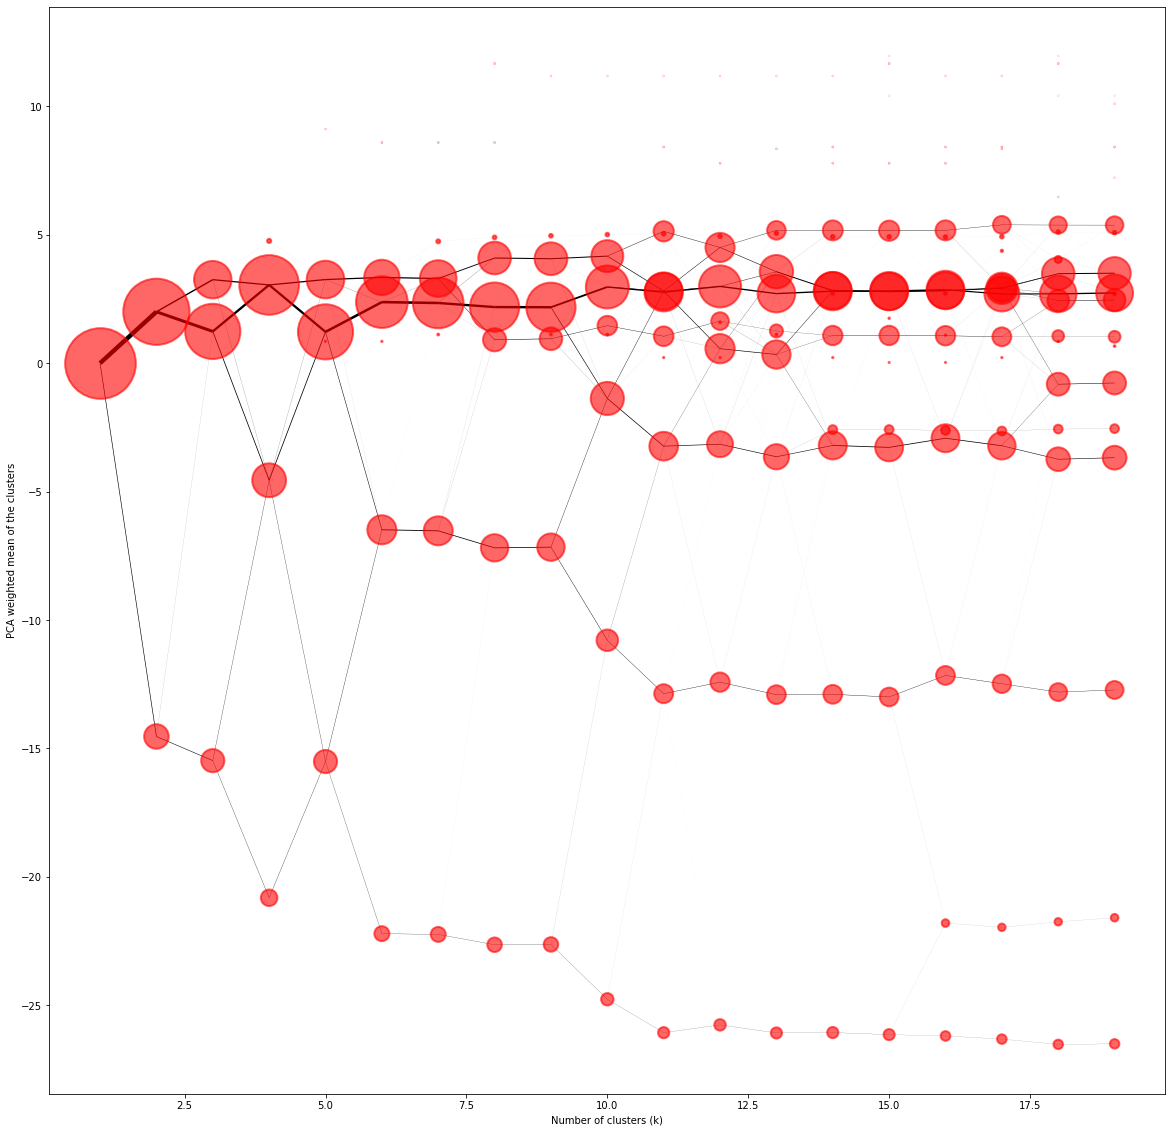

In [34]:
cg.plot(figsize=(20, 20), linewidth=0.1, cluster_style={"edgecolor": "r", "alpha":.6}, size=10)

In [10]:
from cuml import KMeans

In [11]:
km = KMeans(n_clusters=4, n_init=25).fit(scaled_data)

In [12]:
blg = gpd.read_parquet("../../urbangrammar_samba/spatial_signatures/tessellation/tess_8.pq")

In [13]:
blg['clusters'] = km.labels_

In [14]:
blg = blg.set_geometry('buildings')

<AxesSubplot:>

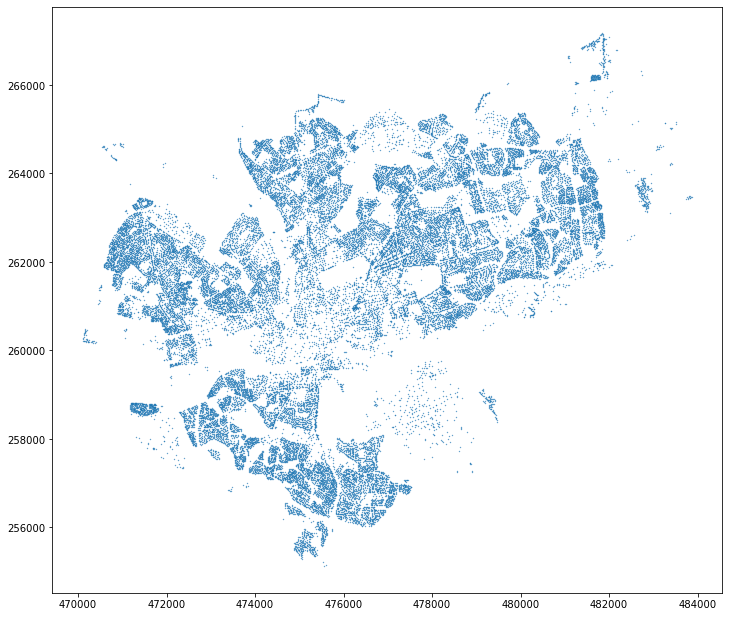

In [52]:
blg[blg.within(Point(475000, 260000).buffer(10000))].centroid.plot(figsize=(12, 12), markersize=.1)

In [15]:
mask = blg.within(Point(475000, 260000).buffer(10000))

In [16]:
nh_data = scaled_data[mask]

In [55]:
nh_data.shape

(35769, 180)

In [56]:
cg = Clustergram(range(1, 30), backend='cuML', n_init=10)
cg.fit(nh_data)

PCA computed in 0.2529337406158447 seconds.
K=1 fitted in 0.684567928314209 seconds.
K=2 fitted in 0.6104063987731934 seconds.
K=3 fitted in 0.6356222629547119 seconds.
K=4 fitted in 0.785851240158081 seconds.
K=5 fitted in 0.8292772769927979 seconds.
K=6 fitted in 0.7981975078582764 seconds.
K=7 fitted in 1.0750820636749268 seconds.
K=8 fitted in 1.2970554828643799 seconds.
K=9 fitted in 1.4786124229431152 seconds.
K=10 fitted in 1.6745054721832275 seconds.
K=11 fitted in 2.027194023132324 seconds.
K=12 fitted in 3.1820240020751953 seconds.
K=13 fitted in 2.805041551589966 seconds.
K=14 fitted in 3.2564637660980225 seconds.
K=15 fitted in 2.8767261505126953 seconds.
K=16 fitted in 2.8673641681671143 seconds.
K=17 fitted in 3.2310702800750732 seconds.
K=18 fitted in 3.710503339767456 seconds.
K=19 fitted in 3.960846424102783 seconds.
K=20 fitted in 3.677273750305176 seconds.
K=21 fitted in 4.135578870773315 seconds.
K=22 fitted in 5.346102237701416 seconds.
K=23 fitted in 6.73633289337

(-10.0, 50.0)

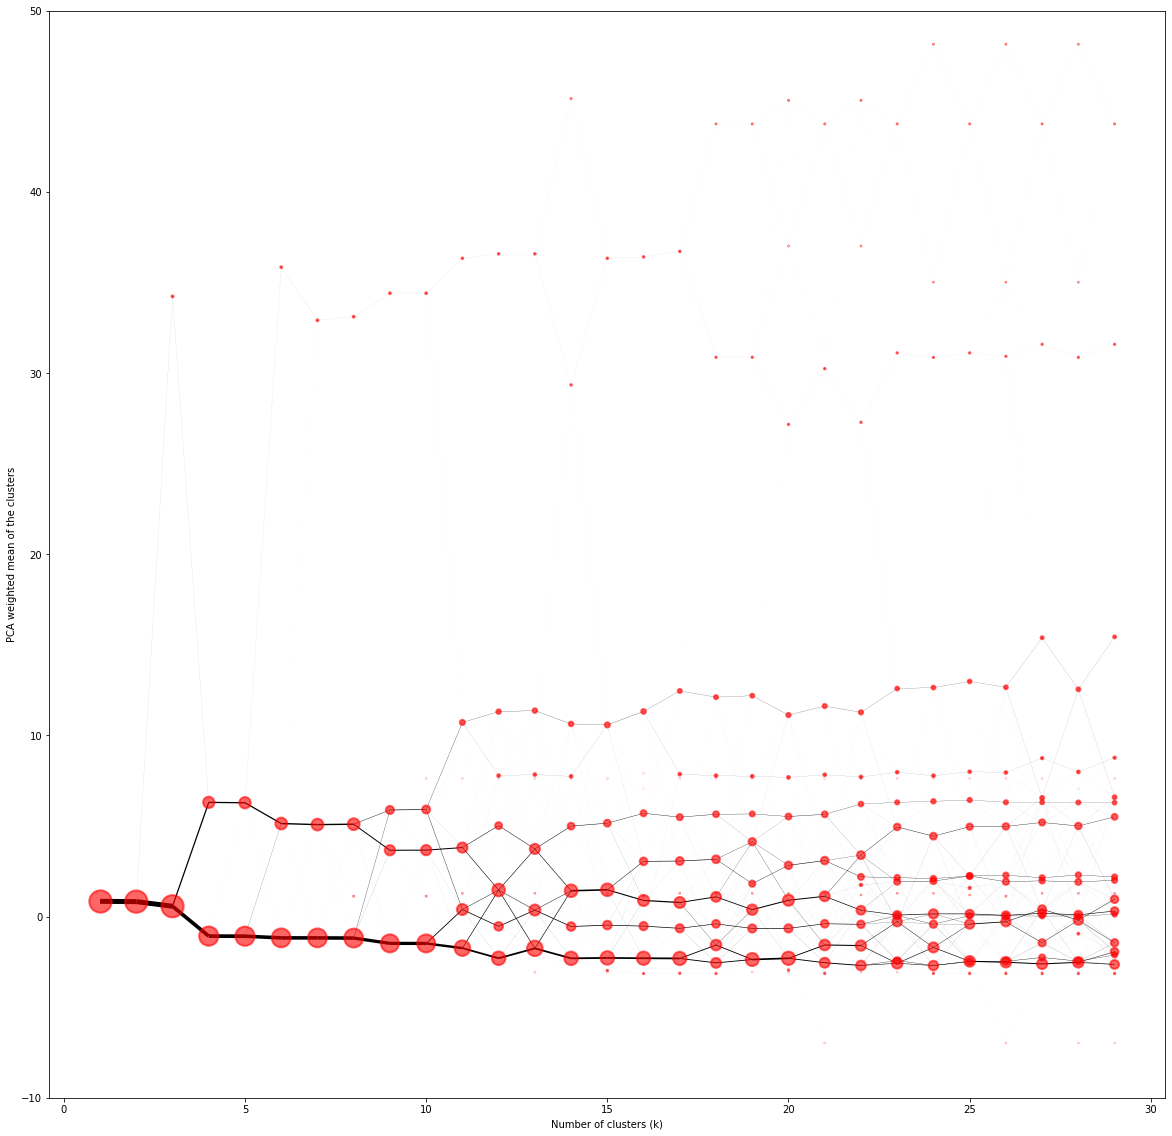

In [59]:
ax = cg.plot(figsize=(20, 20), linewidth=0.1, cluster_style={"edgecolor": "r", "alpha":.6}, size=1)
ax.set_ylim(-10, 50)

In [29]:
km = KMeans(n_clusters=11, n_init=25).fit(nh_data)

In [18]:
nh = blg[blg.within(Point(475000, 260000).buffer(10000))]

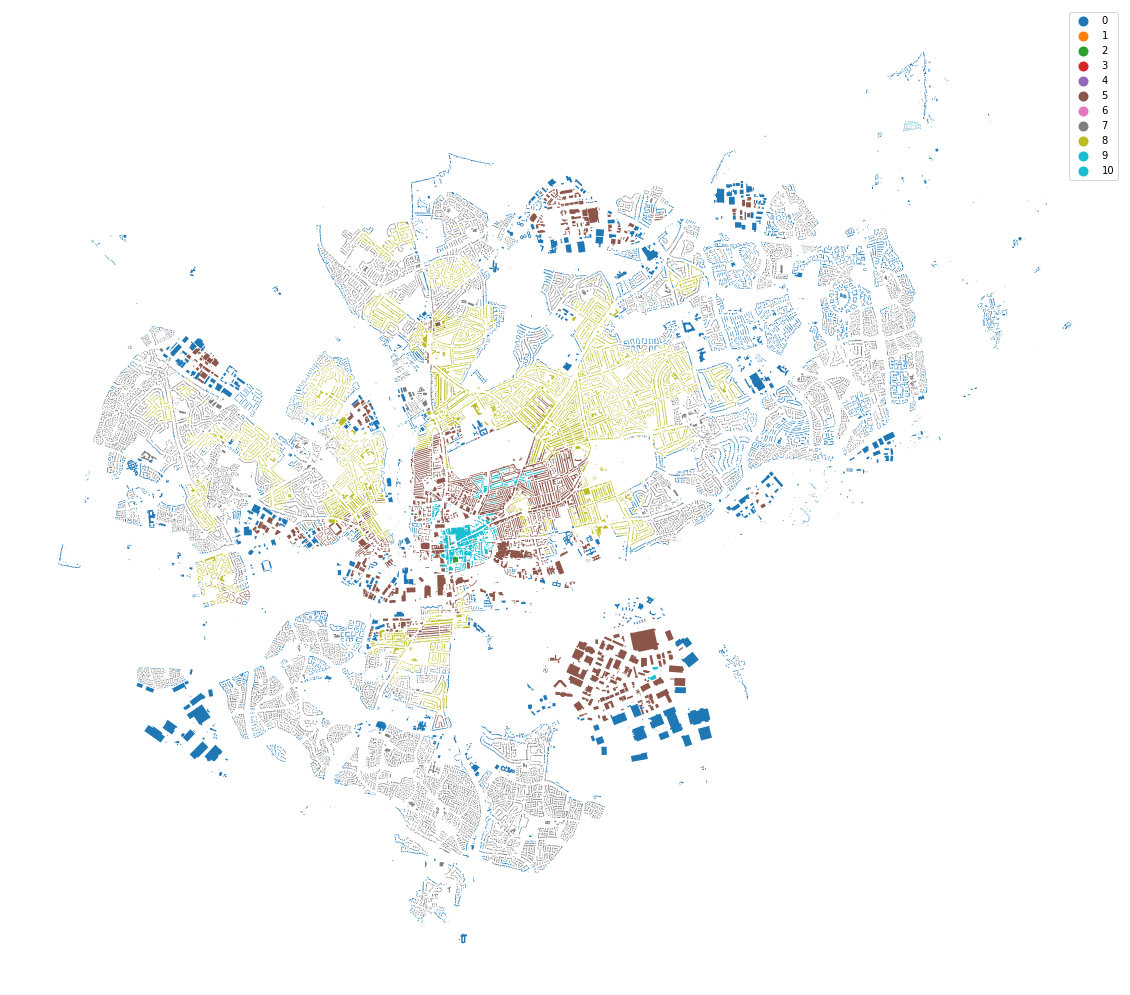

In [30]:
ax = nh.plot(km.labels_, categorical=True, legend=True, figsize=(20, 20), cmap='tab10')
ax.set_axis_off()

In [71]:
nh[['clusters', 'buildings']].to_file('north.gpkg', driver='GPKG')

In [65]:
import contextily

In [21]:
!pip install descartes